In [1]:
#%pip install protobuf==3.20.1

%pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=01f41fa4df823b8bb38d50852c1eedf54fb1624c40fbcc352d17b5cc79f9dc8c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
QPATH = "Quantlet/script_similarity"
PATH = f'/content/drive/MyDrive/ColabNotebooks/IRTG/Encode_the_Qode/Encode-the-Qode/{QPATH}'

In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules

import os
if IN_COLAB:
  os.chdir(PATH)

sys.path.append('../src')

In [4]:
import pickle
import json
import re
import sys
from IPython.display import display

from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import torch

import nltk
nltk.download('punkt')

import importlib
import preprocessing_utils
importlib.reload(preprocessing_utils)

from sentence_transformers import SentenceTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
with open('../../data/preprocessed/Quantlet/Parsed_Qs_with_code_25062023.pkl', 'rb') as file:
  df = pickle.load(file)

CLEAN_UP = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
df = df[df.metainfo_file!='empty']
print(df.shape)

(4856, 6)


In [7]:
def parse_meta(row):
    row = row['metainfo_file']
    if row=='empty':
        return ['','','','']
    dict_keys = list(row.keys())
    dict_key_n = [k.lower() for k in dict_keys]
    name_idx = np.where(['name' in k for k in dict_key_n])[0]
    desc_idx = np.where(['desc' in k for k in dict_key_n])[0]
    key_idx = np.where(['keyw' in k for k in dict_key_n])[0]

    dict_keys_used = []

    if len(name_idx) > 0:
        name = row[dict_keys[name_idx[0]]]
        dict_keys_used.append(name)
    else:
        name = ''
    if len(desc_idx) > 0:
        desc = row[dict_keys[desc_idx[0]]]
        dict_keys_used.append(desc)
    else:
        desc = ''
    if len(key_idx) > 0:
        key = row[dict_keys[key_idx[0]]]
        dict_keys_used.append(key)
    else:
        key = ''
    other = {k: row[k] for k in dict_keys if k not in dict_keys_used}
    return [name, desc, key, other]

In [8]:
# Parse metainfo file
if 'Keywords' not in df.columns:
  meta_info = pd.DataFrame(columns=['Quantlet', 'Description', 'Keywords', 'Other'])

  meta_info[['Quantlet', 'Description', 'Keywords', 'Other']] = df.apply(
      lambda x: parse_meta(x),
      axis='columns',
      result_type='expand'
      )

  for col in meta_info.columns:
      meta_info[col] = meta_info[col].astype(str)

  df = pd.concat([df, meta_info], axis=1)

  del df['metainfo_file']
  del df['Other']
  del df['script_name']
  del df['script_name_no_ext']

In [9]:
df['multiple_scripts'] = df['code_script'].apply(lambda x: any(isinstance(i, list) for i in x))
df['code_script_joined'] = ''
df.loc[df['multiple_scripts']==True, 'code_script_joined'] = df.loc[df['multiple_scripts']==True, 'code_script'].apply(lambda x: [''.join(code_script) for code_script in x])
df.loc[df['multiple_scripts']!=True, 'code_script_joined'] = df.loc[df['multiple_scripts']!=True, 'code_script'].apply(lambda x: [''.join(x)])
df['scr_n'] = df['code_script_joined'].apply(len)

In [10]:
# Create one dataset, each script separate, with the same description and keywords

df_long = df.explode('code_script_joined')
# Create one dataset, one metainfo file, all scripts together


In [11]:
def explode_code_and_lang(df):
    new_df = pd.DataFrame()

    print(f'Shape before exploding scripts: {df.shape}')

    for index, row in tqdm(df.iterrows()):
        if row['multiple_scripts']==True:
          for i, script in enumerate(row['code_script']):
              row['main_script'] = script
              row['main_type_script'] = row['type_script'][i]
              new_df = new_df.append(row)
        else:
          new_df = new_df.append(row)

    new_df['main_script'] = new_df['main_script'].fillna(new_df['code_script'])
    new_df['main_type_script'] = new_df['main_type_script'].fillna(new_df['type_script'])

    new_df = new_df.reset_index(drop=True)
    print(f'Shape after exploding scripts: {new_df.shape}')
    return new_df

df_long = explode_code_and_lang(df)

df_long['code_script'] = df_long['main_script'].progress_apply(lambda x: ''.join(x) if len(x)>0 else np.nan)
df_long['type_script'] = df_long['main_type_script']

del df_long['main_type_script']
del df_long['main_script']
del df_long['code_script_joined']

Shape before exploding scripts: (4856, 9)


4856it [00:18, 258.76it/s]


Shape after exploding scripts: (6743, 11)


100%|██████████| 6743/6743 [00:00<00:00, 70546.75it/s]


In [12]:
model_name = "all-MiniLM-L6-v2"

In [13]:
model = SentenceTransformer(model_name)

In [14]:
df_deduplicated = df_long.drop_duplicates(subset=['folder_name', 'code_script'])
df_deduplicated = df_deduplicated.reset_index(drop=True)

df_deduplicated['repo'] = df_deduplicated['folder_name'].apply(lambda x: re.sub(r'.+(data\/QuantLet\/)([^\/]+)(\/).+', r'\2' , x))
df_deduplicated['repo'] = df_deduplicated['repo'].apply(lambda x: re.sub(r'.+(data\/QuantLet\/)([^\/]+)', r'\2' , x))
print(df_deduplicated.shape)

sample_repos = df_deduplicated['repo'].drop_duplicates().sample(35, random_state=42).unique()
df_sample = df_deduplicated[df_deduplicated.repo.isin(sample_repos)].reset_index(drop=True)

(4857, 9)


In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_sample['repos_id'] = le.fit_transform(df_sample['repo'])

In [16]:
embeddings_df = df_sample.code_script.progress_apply(lambda x: model.encode(x))

embeddings = np.stack(embeddings_df.values)

100%|██████████| 310/310 [00:35<00:00,  8.80it/s]


In [17]:
embeddings.shape

(310, 384)

In [19]:
%pip install umap-learn
import umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=e9b1e297fc16845c928f715d1abbfcebac117af257b80955b3ea8f80c7b1961f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=5209007ad52792181a3fac79d06eec1e62bf6f92c2896c017d8b71da6ea0f339
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [20]:
embeddings

array([[ 0.00548534, -0.09834528,  0.0388503 , ...,  0.02477225,
        -0.07083257, -0.1164805 ],
       [ 0.00548534, -0.09834528,  0.0388503 , ...,  0.02477225,
        -0.07083257, -0.1164805 ],
       [ 0.04556668, -0.06682762,  0.05929982, ..., -0.01599619,
        -0.0803612 , -0.07409099],
       ...,
       [ 0.06492337,  0.00916413, -0.03968532, ...,  0.01723162,
        -0.02710993, -0.03427431],
       [ 0.01604315, -0.02518072,  0.01262758, ...,  0.02369239,
         0.03962155, -0.04570541],
       [ 0.00430855, -0.04005582, -0.00760176, ...,  0.02097075,
         0.11022478, -0.05086005]], dtype=float32)

In [21]:
#!mkdir images

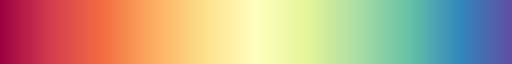

In [22]:
sns.color_palette("Spectral", as_cmap=True)

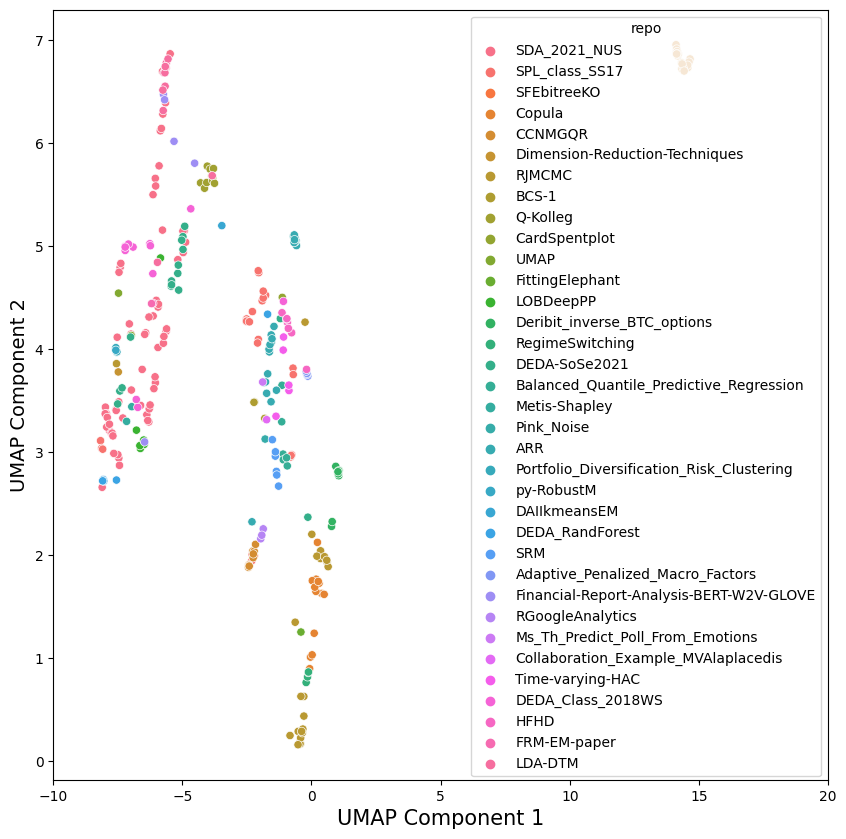

In [23]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15,
                      n_components=2,
                      min_dist=0.0,
                      metric='cosine',
                      random_state=42).fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = df_sample['repos_id']

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=result.x, y=result.y, hue=df_sample['repo'])
plt.xlabel("UMAP Component 1", fontsize=15)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.xlim((-10, 20))
plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim_with_legend.png", transparent=True)
plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim_with_legend.pdf", format='pdf', transparent=True)

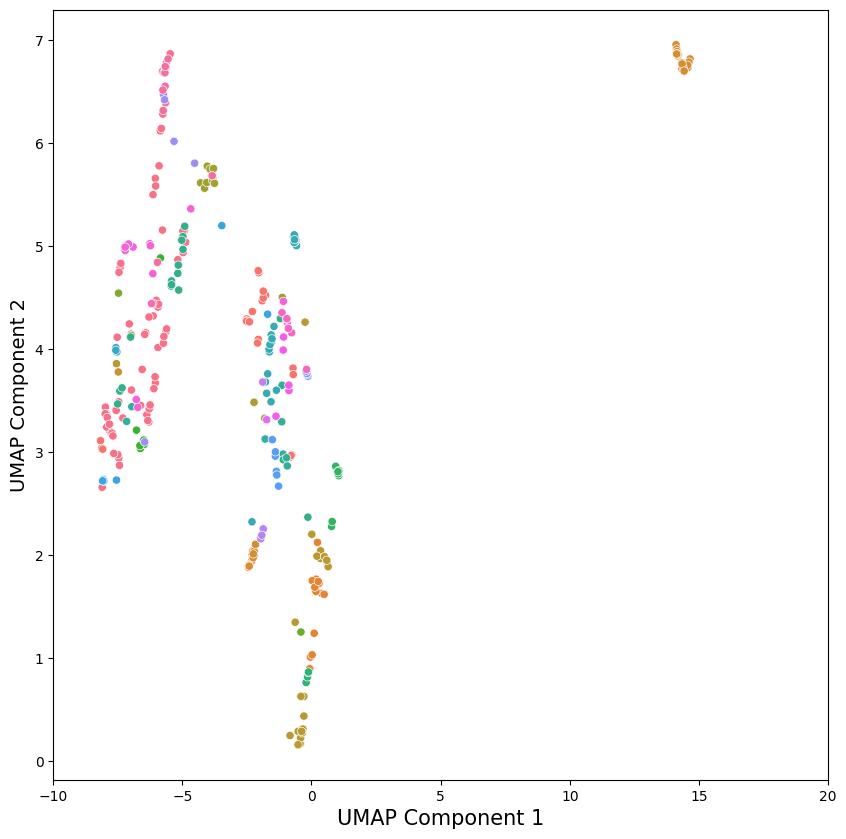

In [24]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=result.x, y=result.y, hue=df_sample['repo'], legend=False)
plt.xlabel("UMAP Component 1", fontsize=15)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.xlim((-10, 20))
plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim.png", transparent=True)
plt.savefig(f"{PATH}/images/scatter_research_tsquare_lim.pdf", format='pdf', transparent=True)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
similarities = cosine_similarity(embeddings)

In [27]:
similarities[[5,4,6], 5]

array([0.9999999, 0.6177007, 0.6308031], dtype=float32)